In [2]:
# Imports for Modeling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import shap
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
)
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_recall_curve,
    roc_auc_score, roc_curve, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from scipy import stats

In [3]:
# Filter Warnings

warnings.filterwarnings('ignore')

## 1. Load Processed Data

### Loading Logic

- Stratified splits for academic replication
- Scaled versions for SVM algorithms
- Proper Series conversion for target variables

### Data Integrity

- Training: 28,860 samples × 22 features
- Test: 7,215 samples × 22 features
- Balanced success rates (7.72% both splits)
- Feature categories sum correctly (3 + 15 + 4 = 22)

### Methodological Rationale

- This follows the academic replication strategy from previous preprocessing and feature engineering notebook, using stratified splits to match Żbikowski & Antosiuk (2021) methodology

In [4]:
# Loading Data for Academic Paper Replication Modeling

print("Loading Data for Academic Paper Replication Modeling")

# Loads the stratified splits (academic paper replication)
print("Loading processed data first")
X_train = pd.read_csv('../data/processed/X_train_stratified.csv')
X_test = pd.read_csv('../data/processed/X_test_stratified.csv')
y_train = pd.read_csv('../data/processed/y_train_stratified.csv').iloc[:, 0]  # Convert to Series
y_test = pd.read_csv('../data/processed/y_test_stratified.csv').iloc[:, 0]    # Convert to Series

# Loads scaled versions for SVM
print("Loading sclaed versions for SVM second")
X_train_scaled = pd.read_csv('../data/processed/X_train_scaled.csv')
X_test_scaled = pd.read_csv('../data/processed/X_test_scaled.csv')

print(f"Training set: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]:,} samples, {X_test.shape[1]} features")
print(f"Training success rate: {y_train.mean()*100:.2f}%")
print(f"Test success rate: {y_test.mean()*100:.2f}%")

# Feature categories for analysis
geographic_features = ['region_startup_density', 'city_startup_density', 'is_usa']
industry_features = [col for col in X_train.columns if col.startswith('category_')]
temporal_features = ['founded_year_std', 'era_dotcom_era', 'era_post_crash', 'era_recovery']

print(f"\nFeature breakdown:")
print(f"- Geographic features: {len(geographic_features)}")
print(f"- Industry features: {len(industry_features)}")
print(f"- Temporal features: {len(temporal_features)}")
print(f"- Total features: {len(geographic_features) + len(industry_features) + len(temporal_features)}")


Loading Data for Academic Paper Replication Modeling
Loading processed data first
Loading sclaed versions for SVM second
Training set: 28,860 samples, 22 features
Test set: 7,215 samples, 22 features
Training success rate: 7.72%
Test success rate: 7.72%

Feature breakdown:
- Geographic features: 3
- Industry features: 15
- Temporal features: 4
- Total features: 22


## 2. Baseline Model Setup

### Cross Validation Strategy

- 5 fold stratified CV is a proper choice for imbalanced dataset (7.72% success rate)
- shuffle=True with random_state=42 ensures reproducible results
- Stratification maintains class balance across all folds

### Evaluation Metrics

- Proper choices for imbalanced classification: precision, recall, f1, roc_auc
- Matches academic paper's (Żbikowski & Antosiuk (2021)) evaluation framework
- Avoids accuracy (it would be misleading with 92.28% negative class)

### Academic Benchmarks

- Are correctly extracted from Żbikowski & Antosiuk (2021)
- Clear performance targets for validation
- F1-score of 43% reflects the precision/recall balance

In [5]:
# Baseline Model Setup/Configuration

print("Baseline Model Setup")

# Sets up cross validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Cross-validation: 5-fold stratified")

# Defines scoring metrics (academic paper replication metrics)
scoring_metrics = ['precision', 'recall', 'f1', 'roc_auc']
print(f"Evaluation metrics: {scoring_metrics}")

# Academic targets from academic paper: Żbikowski & Antosiuk (2021)
TARGET_PRECISION = 0.57
TARGET_RECALL = 0.34
TARGET_F1 = 0.43

print(f"\nAcademic targets to match/exceed:")
print(f"- Precision: {TARGET_PRECISION:.0%}")
print(f"- Recall: {TARGET_RECALL:.0%}")
print(f"- F1-Score: {TARGET_F1:.0%}")

Baseline Model Setup
Cross-validation: 5-fold stratified
Evaluation metrics: ['precision', 'recall', 'f1', 'roc_auc']

Academic targets to match/exceed:
- Precision: 57%
- Recall: 34%
- F1-Score: 43%


## 3. MODEL 1: Logistic Regression (With Regularization)

### Transformation Applied

- **Hyperparameter Grid Implementation**: Designed systematic parameter space exploration covering regularization strength (C: 0.001-100), penalty types (L1/L2), class weighting strategies (None/balanced), and solver configuration (liblinear) to identify optimal model configuration for imbalanced startup classification task
- **Grid Search Cross-Validation Execution**: Applied 5 fold stratified cross validation across 24 hyperparameter combinations (120 total model fits), optimizing for F1-score to balance precision-recall tradeoffs critical for startup success prediction where both false positives and false negatives carry significant business costs
- **Optimal Configuration Selection**: Identified best performing parameters through systematic evaluation: C=1 (moderate regularization), L1 penalty (feature selection capability), balanced class weighting (addressing 7.72% positive class imbalance), and liblinear solver (efficient for L1/L2 penalties)
- **Model Evaluation Pipeline**: Executed comprehensive performance assessment using test set predictions, calculating precision (16.9%), recall (70.9%), F1-score (27.3%), and AUC-ROC (78.1%) metrics against academic benchmarks from Żbikowski & Antosiuk (2021) research

### Methodological Rationale

- **Academic Replication Compliance**: Applied identical evaluation framework to published research methodology, enabling direct performance comparison with established benchmarks (57% precision, 34% recall, 43% F1-score) while maintaining consistent cross validation and scoring approaches
- **Imbalanced Classification Optimization**: Implemented balanced class weighting to address severe class imbalance (92.28% negative class), preventing model bias toward majority class predictions that would achieve high accuracy but fail to identify startup success patterns
- **Regularization Strategy Selection**: L1 penalty selection enables automatic feature selection during training, identifying most predictive features among 22 founding time variables while preventing overfitting in high dimensional feature space relative to positive class sample size
- **F1-Score Optimization Focus**: Targeted F1-score maximization during hyperparameter tuning to achieve optimal precision recall balance, reflecting real world venture capital decision-making where both missed opportunities (false negatives) and wasted due diligence (false positives) impose significant costs

### Performance Analysis

- **Recall Excellence vs Precision Challenge**: Achieved exceptional recall performance (70.9%) exceeding academic target by 2.1x, successfully identifying 71% of actual startup successes, but suffered from low precision (16.9%) indicating high false positive rate with only 17% of positive predictions being correct
- **Class Imbalance Impact**: Balanced class weighting strategy effectively addressed minority class detection but created precision recall tradeoff where model sensitivity improvement came at cost of prediction specificity, resulting in 83% false positive rate among predicted successes
- **Discriminative Capability Validation**: Strong AUC-ROC performance (78.1%) demonstrates robust ranking ability to distinguish successful from unsuccessful startups, indicating feature set contains meaningful predictive signals despite precision challenges
- **Academic Benchmark Comparison**: Performance gap relative to published targets (F1: 27.3% vs 43% target) suggests potential differences in dataset characteristics, feature engineering approaches, or evaluation methodologies between current implementation and original research

### ML Pipeline Impact

- **Feature Selection Insights**: L1 regularization with C=1 provides automatic feature selection capability, enabling identification of most predictive founding-time characteristics while eliminating noisy variables that could degrade model generalization performance
- **Threshold Optimization Potential**: High AUC-ROC (78.1%) combined with precision recall imbalance indicates significant opportunity for prediction threshold tuning to achieve business-specific cost-sensitive optimization balancing investor risk tolerance and opportunity identification
- **Baseline Model Establishment**: Results provide solid foundation for ensemble method comparison, with 70.9% recall representing upper bound for startup success detection while highlighting need for precision improvement through alternative algorithms
- **Production Deployment Considerations**: Model demonstrates strong sensitivity for screening applications where missing potential successes carries higher cost than investigating false positives, suitable for initial filtering in venture capital deal flow management systems
- **Cross-Validation Stability**: Best CV F1-score (26.7%) closely matches test performance (27.3%), indicating robust generalization without overfitting concerns and reliable performance estimation for production deployment scenarios
- **Business Interpretation Framework**: Balanced class weighting with L1 regularization creates interpretable model where feature coefficients directly indicate founding time characteristics that increase/decrease acquisition probability, supporting stakeholder communication and investment decision justification processes

In [6]:
# MODEL 1: Logisitic Regression w/ regularization

print("MODEL 1: Logistic Regression with Regularization")

# Hyperparameter grid for logistic regression
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],  # Works with L1 and L2
    'class_weight': [None, 'balanced'],
    'max_iter': [1000]
}

print("Hyperparameter Grid:")
for param, values in lr_param_grid.items():
    print(f"  {param}: {values}")

# Grid search with cross validation
print("Running Grid Search Now")
lr_grid = GridSearchCV(
    LogisticRegression(random_state=42),
    lr_param_grid,
    cv=cv_strategy,
    scoring='f1',  # Optimize for F1 (balanced precision/recall)
    n_jobs=-1,
    verbose=1
)

lr_grid.fit(X_train, y_train)

print("Best Logistic Regression parameters:")
print(lr_grid.best_params_)
print(f"Best Cross Validation F1-score: {lr_grid.best_score_:.3f}")

# Evaluating the best model
lr_best = lr_grid.best_estimator_
lr_pred = lr_best.predict(X_test)
lr_pred_proba = lr_best.predict_proba(X_test)[:, 1]

# Calculates the metrics
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_pred_proba)

print(f"\nLogistic Regression Results:")
print(f"- Precision: {lr_precision:.3f} (Target: {TARGET_PRECISION:.3f})")
print(f"- Recall: {lr_recall:.3f} (Target: {TARGET_RECALL:.3f})")
print(f"- F1-Score: {lr_f1:.3f} (Target: {TARGET_F1:.3f})")
print(f"- AUC-ROC: {lr_auc:.3f}")

MODEL 1: Logistic Regression with Regularization
Hyperparameter Grid:
  C: [0.001, 0.01, 0.1, 1, 10, 100]
  penalty: ['l1', 'l2']
  solver: ['liblinear']
  class_weight: [None, 'balanced']
  max_iter: [1000]
Running Grid Search Now
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Logistic Regression parameters:
{'C': 1, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross Validation F1-score: 0.267

Logistic Regression Results:
- Precision: 0.169 (Target: 0.570)
- Recall: 0.709 (Target: 0.340)
- F1-Score: 0.273 (Target: 0.430)
- AUC-ROC: 0.781


## 4. MODEL 2: SVM (Support Vector Machine) with RBF (Radial Basis Function) Kernel

### Transformation Applied

- **Reduced Hyperparameter Grid Strategy**: Implemented computationally efficient parameter space exploration with focused ranges: regularization parameter C (0.5-5), RBF kernel gamma values (0.05-0.5), fixed RBF kernel selection, and balanced class weighting, totaling 16 hyperparameter combinations for faster training while maintaining comprehensive coverage
- **Scaled Feature Preprocessing**: Applied StandardScaler transformation to training and test datasets ensuring zero mean unit variance normalization critical for SVM distance-based optimization, preventing feature scale bias that could dominate decision boundary formation in high dimensional startup characteristic space
- **Probability Calibration Integration**: Enabled probability estimation through SVC probability=True parameter for AUC-ROC calculation compatibility, allowing comprehensive model evaluation across multiple metrics while maintaining SVM's discriminative classification capabilities
- **Optimal Configuration Identification**: Selected best performing parameters through systematic grid search: C=1 (moderate regularization), gamma=0.1 (balanced kernel width), RBF kernel (non linear decision boundaries), and balanced class weighting, achieving 25.7% cross-validation F1-score across 80 total model fits

### Methodological Rationale

- **Feature Scaling Necessity**: SVM algorithm sensitivity to feature magnitude differences requires standardization to prevent geographic density features (1-5 range) from being overshadowed by standardized founding year variables, ensuring equal contribution to decision boundary optimization and preventing algorithmic bias toward specific feature scales
- **RBF Kernel Selection Justification**: Radial Basis Function kernel enables detection of non linear relationships between founding time characteristics and startup success probability, capturing complex interaction patterns (geographic-industry synergies, temporal-sector dependencies) that linear models cannot represent effectively
- **Gamma Parameter Optimization Focus**: Gamma controls RBF kernel width determining decision boundary complexity, with optimal value (0.1) balancing model flexibility to capture startup success patterns against overfitting risk in 22-dimensional feature space with 7.72% positive class samples
- **Computational Efficiency Strategy**: Reduced parameter grid (16 vs potential 100+ combinations) maintains thorough hyperparameter exploration while enabling practical training time on 28,860-sample dataset, balancing model optimization thoroughness with computational resource constraints

### Performance Analysis

- **Precision-Recall Tradeoff Consistency**: Achieved similar performance profile to Logistic Regression with moderate precision (15.5%) and strong recall (68.9%), indicating both algorithms identify similar startup success patterns but struggle with false positive control in severely imbalanced classification scenario
- **Performance Gap vs Linear Model**: SVM F1-score (25.2%) trails Logistic Regression (27.3%) by 2.1 percentage points, suggesting linear decision boundaries may be sufficient for founding time feature relationships, questioning complexity benefit of non linear kernel approach for this specific prediction task
- **Academic Benchmark Underperformance**: Results fall significantly short of published targets (F1: 25.2% vs 43% target, precision: 15.5% vs 57% target), indicating either dataset differences, feature engineering variations, or need for advanced ensemble methods to achieve competitive performance levels
- **AUC-ROC Discriminative Assessment**: Moderate AUC-ROC performance (74.0%) demonstrates reasonable ranking ability but 4.1 percentage point decline vs Logistic Regression (78.1%) suggests RBF kernel complexity may introduce noise rather than capturing meaningful non linear patterns in startup success prediction

### ML Pipeline Impact

- **Algorithm Comparison Baseline**: SVM results provide critical comparison point validating that linear relationships dominate founding-time startup characteristics, informing ensemble strategy to emphasize linear models over complex non-linear approaches for optimal performance balance
- **Feature Engineering Validation**: Similar precision recall patterns across linear and non-linear models confirm feature set captures primary startup success signals effectively, indicating preprocessing pipeline success while highlighting need for advanced sampling techniques rather than feature complexity increases
- **Computational Resource Assessment**: Reduced training time through focused hyperparameter grid demonstrates practical deployment considerations for real time prediction systems, where SVM computational overhead may not justify marginal performance improvements over efficient linear alternatives
- **Class Imbalance Handling Effectiveness**: Balanced class weighting produces consistent recall performance (68.9%) across algorithm types, validating imbalanced classification strategy while emphasizing need for precision improvement through threshold optimization or ensemble resampling techniques
- **Production Deployment Considerations**: SVM model provides reliable backup algorithm with different algorithmic assumptions, enabling ensemble diversity and robustness against edge cases where linear assumptions fail, while scaled feature requirements ensure consistent preprocessing pipeline across deployment scenarios
- **Model Interpretability Limitations**: RBF kernel decision boundaries lack direct feature coefficient interpretation compared to L1 regularized Logistic Regression, reducing stakeholder communication effectiveness and limiting business insight generation for venture capital investment decision support frameworks

In [7]:
# MODEL 2: SVM w/ RBF Kernel

print("MODEL 2: SVM w/ RBF Kernel")

# Hyperparameter grid for SVM (using scaled features)
svm_param_grid = {
    'C': [0.5, 1, 2, 5],
    'gamma': [0.05, 0.1, 0.2, 0.5],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}

print("Reduced Hyperparameter Grid (faster training):")
for param, values in svm_param_grid.items():
    print(f"  {param}: {values}")

# Grid search with cross validation (using scaled data)
print("\nRunning Grid Search on scaled features...")
svm_grid = GridSearchCV(
    SVC(probability=True, random_state=42),  # Enable probability for AUC
    svm_param_grid,
    cv=cv_strategy,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(X_train_scaled, y_train)

print("Best SVM parameters:")
print(svm_grid.best_params_)
print(f"Best CV F1-score: {svm_grid.best_score_:.3f}")

# Evaluating the best model
svm_best = svm_grid.best_estimator_
svm_pred = svm_best.predict(X_test_scaled)
svm_pred_proba = svm_best.predict_proba(X_test_scaled)[:, 1]

# Calculates the metrics
svm_precision = precision_score(y_test, svm_pred)
svm_recall = recall_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred)
svm_auc = roc_auc_score(y_test, svm_pred_proba)

print(f"\nSVM Results:")
print(f"- Precision: {svm_precision:.3f} (Target: {TARGET_PRECISION:.3f})")
print(f"- Recall: {svm_recall:.3f} (Target: {TARGET_RECALL:.3f})")
print(f"- F1-Score: {svm_f1:.3f} (Target: {TARGET_F1:.3f})")
print(f"- AUC-ROC: {svm_auc:.3f}")

MODEL 2: SVM w/ RBF Kernel
Reduced Hyperparameter Grid (faster training):
  C: [0.5, 1, 2, 5]
  gamma: [0.05, 0.1, 0.2, 0.5]
  kernel: ['rbf']
  class_weight: ['balanced']

Running Grid Search on scaled features...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best SVM parameters:
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}
Best CV F1-score: 0.257

SVM Results:
- Precision: 0.155 (Target: 0.570)
- Recall: 0.689 (Target: 0.340)
- F1-Score: 0.252 (Target: 0.430)
- AUC-ROC: 0.740


## 5. MODEL 3: XGBoost

### Transformation Applied

- **Hyperparameter Grid Implementation**: Designed parameter space exploration covering ensemble configuration (n_estimators: 100-300), tree complexity (max_depth: 3-5), learning dynamics (learning_rate: 0.01-0.1), regularization strategies (subsample: 0.8-1.0, colsample_bytree: 0.8-1.0), and class imbalance handling (scale_pos_weight: 1-10) to identify optimal XGBoost configuration for imbalanced startup classification task
- **Randomized Search Cross-Validation Execution**: Applied efficient randomized search across 50 parameter combinations (250 total model fits) using 5 fold stratified crossvvalidation, optimizing for F1-score to balance precision-recall tradeoffs while reducing computational overhead compared to exhaustive grid search approach for high dimensional hyperparameter space
- **Optimal Configuration Selection**: Identified best performing parameters through systematic evaluation: subsample=0.8 (regularization through row sampling), scale_pos_weight=5 (moderate class imbalance compensation), n_estimators=100 (ensemble size), max_depth=3 (controlled tree complexity), learning_rate=0.1 (balanced learning speed), colsample_bytree=0.8 (feature sampling regularization)
- **Model Evaluation Pipeline**: Executed comprehensive performance assessment using test set predictions, calculating precision (23.4%), recall (38.8%), F1-score (29.1%), and AUC-ROC (79.0%) metrics against academic benchmarks from Żbikowski & Antosiuk (2021) research

### Methodological Rationale

- **Academic Replication Excellence**: XGBoost represents the best performing algorithm from original research, enabling direct validation of gradient boosting effectiveness for startup success prediction while maintaining identical evaluation framework and bias free methodology for fair benchmark comparison
- **Ensemble Learning Optimization**: Gradient boosting architecture addresses imbalanced classification challenges through sequential weak learner improvement, iterative residual correction, and adaptive sample weighting that naturally handles minority class detection better than single-model approaches
- **Class Imbalance Strategy Integration**: scale_pos_weight=5 provides targeted class imbalance handling by increasing penalty for false negatives on minority class (successful startups), balancing the 12:1 class ratio without requiring external resampling techniques that could introduce data artifacts
- **Regularization Framework Deployment**: Combined row sampling (subsample=0.8) and feature sampling (colsample_bytree=0.8) prevents overfitting while maintaining predictive power, particularly important for founding-time feature constraints where data richness is limited compared to post-founding information

### Performance Analysis

- **Balanced Performance Achievement**: Achieved superior F1-score balance (29.1%) compared to previous models through optimal precision recall tradeoff, with precision (23.4%) showing significant improvement over Logistic Regression (16.9%) while maintaining competitive recall (38.8%) for comprehensive startup success detection
- **Academic Benchmark Convergence**: F1-score (29.1%) approaches published target (43.0%) more closely than linear models, representing 67.7% of academic benchmark achievement while demonstrating ensemble method superiority for complex startup ecosystem pattern recognition
- **Recall Optimization Excellence**: Recall performance (38.8%) exceeds academic target (34.0%) by 14.1%, successfully identifying 39% of actual startup successes while maintaining more controlled false positive rate compared to previous high recall models
- **Discriminative Capability Leadership**: Strongest AUC-ROC performance (79.0%) among all models demonstrates superior ranking ability to distinguish successful from unsuccessful startups, indicating gradient boosting effectively captures non-linear relationships in founding time feature interactions

### ML Pipeline Impact

- **Feature Interaction Discovery**: XGBoost's tree based architecture automatically detects complex feature interactions (geographic-industry synergies, temporal sector patterns) that linear models cannot capture, enabling discovery of previously unknown predictive patterns in startup ecosystem data
- **Regularization Effectiveness Validation**: Optimal hyperparameters (subsample=0.8, colsample_bytree=0.8) demonstrate that regularization is critical for founding time feature constraints, preventing overfitting while maintaining predictive signal strength in limited information environment
- **Class Imbalance Handling Superiority**: scale_pos_weight=5 provides more nuanced class imbalance treatment than binary balanced approaches, achieving optimal minority class detection without excessive false positive generation that could undermine practical deployment effectiveness
- **Ensemble Model Foundation**: Results establish XGBoost as strongest individual model, providing foundation for meta learning approaches where XGBoost predictions could serve as key features in stacked ensemble architectures for further performance improvement
- **Cross-Validation Stability Excellence**: Best CV F1-score (29.7%) closely matches test performance (29.1%), indicating robust generalization without overfitting concerns and reliable performance estimation for production deployment scenarios across different data partitions
- **Business Decision Support Enhancement**: Superior precision-recall balance makes XGBoost most suitable for practical venture capital applications where both missed opportunities (false negatives) and wasted due diligence (false positives) carry significant costs, supporting risk balanced investment screening processes

In [8]:
# MODEL 3: XGBoost (Academic Paper Best Preforming Model)

print("MODEL 3: XGBoost")

# Hyperparamter Grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'scale_pos_weight': [1, 5, 10]  # Handles class imbalance (12:1 ratio)
}

print("Hyperparameter Grid:")
for param, values in xgb_param_grid.items():
    print(f"  {param}: {values}")

# Randomized search (more efficient than grid search for XGBoost)
print("\nRunning Randomized Search...")
xgb_random = RandomizedSearchCV(
    xgb.XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    ),
    xgb_param_grid,
    n_iter=50,  # 50 random combinations
    cv=cv_strategy,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

xgb_random.fit(X_train, y_train)

print("Best XGBoost parameters:")
print(xgb_random.best_params_)
print(f"Best CV F1-score: {xgb_random.best_score_:.3f}")

# Evaluates best model
xgb_best = xgb_random.best_estimator_
xgb_pred = xgb_best.predict(X_test)
xgb_pred_proba = xgb_best.predict_proba(X_test)[:, 1]

# Calculates the metrics
xgb_precision = precision_score(y_test, xgb_pred)
xgb_recall = recall_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)
xgb_auc = roc_auc_score(y_test, xgb_pred_proba)

print(f"\nXGBoost Results:")
print(f"- Precision: {xgb_precision:.3f} (Target: {TARGET_PRECISION:.3f})")
print(f"- Recall: {xgb_recall:.3f} (Target: {TARGET_RECALL:.3f})")
print(f"- F1-Score: {xgb_f1:.3f} (Target: {TARGET_F1:.3f})")
print(f"- AUC-ROC: {xgb_auc:.3f}")

MODEL 3: XGBoost
Hyperparameter Grid:
  n_estimators: [100, 200, 300]
  max_depth: [3, 4, 5]
  learning_rate: [0.01, 0.1]
  subsample: [0.8, 0.9, 1.0]
  colsample_bytree: [0.8, 0.9, 1.0]
  scale_pos_weight: [1, 5, 10]

Running Randomized Search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best XGBoost parameters:
{'subsample': 0.8, 'scale_pos_weight': 5, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best CV F1-score: 0.297

XGBoost Results:
- Precision: 0.234 (Target: 0.570)
- Recall: 0.388 (Target: 0.340)
- F1-Score: 0.291 (Target: 0.430)
- AUC-ROC: 0.790


## 6. Model Comparison and Academic Validation

### Performance Summary

This evaluation of three machine learning algorithms/models reveals distinct performance patterns when predicting startup success using founding time features only

### Results Table

| Model | Precision | Recall | F1-Score | AUC-ROC |
|-------|-----------|--------|----------|---------|
| **Logistic Regression** | 0.169 | 0.709 | 0.273 | 0.781 |
| **SVM (RBF)** | 0.155 | 0.689 | 0.252 | 0.740 |
| **XGBoost** | 0.234 | 0.388 | 0.291 | 0.790 |
| **Academic Target** | 0.570 | 0.340 | 0.430 | NA |

### Best Performing Model

**XGBoost** with F1-Score of **0.291**, Precision of 0.234, Recall of 0.388, and AUC-ROC of 0.790

## 5.2 Academic Validation Analysis

### 5.2.1 Benchmark Comparison

Our models were evaluated against the academic targets from Żbikowski & Antosiuk (2021):
- Target Precision: **57.0%**
- Target Recall: **34.0%**
- Target F1-Score: **43.0%**

### Performance Gap Analysis

- **Critical Finding**: No models met or exceeded the academic F1 target of 43.0%
- **Precision Gap**: All models underperformed (16.9% vs 57.0% target)
- **Recall Advantage**: Linear models (Logistic Regression, SVM) exceeded recall targets by 2x
- **F1-Score Gap**: Best model (XGBoost) achieved 67.7% of academic benchmark

### Model Specific Analysis

**Logistic Regression**
- **Strengths**: Highest recall (70.9%), excellent minority class detection
- **Weaknesses**: Lowest precision (16.9%), high false positive rate
- **Pattern**: High sensitivity, low specificity

**SVM (RBF Kernel)**
- **Strengths**: Consistent with linear model patterns
- **Weaknesses**: Lowest overall performance across all metrics
- **Insight**: RBF complexity didn't improve upon linear relationships

**XGBoost**
- **Strengths**: Best precision recall balance, highest F1-score and AUC-ROC
- **Advantages**: Superior feature interaction detection, optimal regularization
- **Business Value**: Most suitable for practical deployment if part of overall goal/mission

### Methodological Insights


- The consistent underperformance across all models suggests that **founding time features alone** may be insufficient for achieving academic benchmark performance, indicating:
    - **Information Constraint**: Limited predictive signal from incorporation time data
    - **Dataset Differences**: Potential variations in data quality or preprocessing approaches
    - **Temporal Effects**: Different economic conditions between studies
    
- The precision recall tradeoff pattern across all models reflects the challenge of **severe class imbalance** (7.72% success rate):
    - High recall models identify most successes but generate many false positives
    - Balanced approaches (XGBoost) provide better practical deployment characteristics
    - All models demonstrate reasonable discriminative ability (AUC-ROC 74-79%)
    
- **Linear relationships** could possibly dominate founding time features, as evidenced by:
    - SVM RBF underperforming compared to linear approaches
    - XGBoost's tree-based ensemble providing marginal improvement
    - Similar recall patterns across different algorithmic assumptions

### Academic Validation Conclusion

- While none of the models achieved the academic performance targets, this outcome provides valuable insights:
    - **Methodological Validation**: Confirms the difficulty of bias-free startup success prediction
    - **Dataset Authenticity**: Results align with realistic startup ecosystem challenges
    - **Practical Value**: Models still provide meaningful screening and ranking capabilities
    - **Research Gap**: Identifies opportunities for advanced ensemble methods and feature engineering
- The 67.7% achievement of academic F1-score benchmark by XGBoost represents a solid foundation for further model development and demonstrates the viability of founding time feature approaches for practical startup success prediction applications. More model development is needed for increased success

In [9]:
# Model Comparison and Academic Validation

print("Model Comparison and Academic Validation")

# Comparison Table
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM (RBF)', 'XGBoost', 'Academic Target'],
    'Precision': [lr_precision, svm_precision, xgb_precision, TARGET_PRECISION],
    'Recall': [lr_recall, svm_recall, xgb_recall, TARGET_RECALL],
    'F1-Score': [lr_f1, svm_f1, xgb_f1, TARGET_F1],
    'AUC-ROC': [lr_auc, svm_auc, xgb_auc, np.nan]
})

print("Performance Comparison:")
print(results_df.round(3).to_string(index=False))

# Identifies the best model
best_f1_idx = results_df['F1-Score'][:-1].idxmax()  # Excluded academic target
best_model_name = results_df.loc[best_f1_idx, 'Model']
best_f1_score = results_df.loc[best_f1_idx, 'F1-Score']

print(f"\nBEST MODEL: {best_model_name}")
print(f"F1-Score: {best_f1_score:.3f}")

# Academic Validation Check
models_beating_target = results_df[results_df['F1-Score'] > TARGET_F1]['Model'].tolist()
if 'Academic Target' in models_beating_target:
    models_beating_target.remove('Academic Target')

if models_beating_target:
    print(f"Models exceeding academic target: {', '.join(models_beating_target)}")
else:
    print("No models exceeded academic F1 target of 43.0%")



Model Comparison and Academic Validation
Performance Comparison:
              Model  Precision  Recall  F1-Score  AUC-ROC
Logistic Regression      0.169   0.709     0.273    0.781
          SVM (RBF)      0.155   0.689     0.252    0.740
            XGBoost      0.234   0.388     0.291    0.790
    Academic Target      0.570   0.340     0.430      NaN

BEST MODEL: XGBoost
F1-Score: 0.291
No models exceeded academic F1 target of 43.0%


## 7. Feature Importance Analysis

### Key Findings

**XGBoost Most Important Features**:

1. **Temporal Era**
   - era_recovery (18.31%) - Recovery period after dot com crash
   - era_post_crash (8.55%) - Post crash era
   - era_dotcom_era (5.97%) - Dot-com boom period
   - Combined temporal importance: **48.9%** of total feature importance

2. **Geographic Location**
   - is_usa (7.01%) - Being in the US is a strong predictor
   - city_startup_density and region_startup_density also feature prominently
   - Total geographic importance: **13.7%**

3. **Industry Categories**
   - category_biotechnology (5.04%) - Biotech companies stand out
   - Various tech categories (web, advertising, health, enterprise) all feature
   - Total industry importance: **37.4%**

### Logistic Regression Insights (Coefficient Interpretation)

**Positive Predictors (Increase Success Probability):**
- Being in USA (+0.635)
- Advertising category (+0.627)
- Analytics category (+0.557)
- Mobile category (+0.438)

**Negative Predictors (Decrease Success Probability):**
- Later founding year (-1.020)
   - Earlier companies more successful
- Biotechnology (-0.662)
   - Contrasts with XGBoost importance
- Dot com era (-0.869)
   - Was not expected honestly
- Health category (-0.593)

### Important Observations

- **Era Effects Are Crucial:** Nearly 50% of XGBoost's decision making relies on when companies were founded, suggests strong temporal patterns in startup success
- **Geographic Advantage:** US location provides a significant advantage, consistent with the concentration of startup ecosystems and venture capital
- **Industry Paradoxes:** Biotechnology shows high importance in XGBoost but negative coefficient in Logistic Regression. This suggests complex non linear relationships that tree based models capture better
- **Model Differences:** The contrasting signs between XGBoost importance and Logistic Regression coefficients highlight why XGBoost performed better. It can capture complex interactions that linear models miss
- This analysis validates XGBoost as the best model, as it's clearly capturing nuanced patterns that the linear logistic regression cannot represent effectively

In [10]:
# Feature Importance Analysis

print("Feature Importance Analysis")

# XGBoost feature importance (assumes as best model (it is))
if best_model_name == 'XGBoost':
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_best.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 15 Most Important Features (XGBoost):")
    print("="*50)
    for i, (_, row) in enumerate(feature_importance.head(15).iterrows(), 1):
        print(f"{i:2d}. {row['feature']:<25} {row['importance']:.4f}")

# Feature importance by category
print(f"\nFeature importance by category:")
geo_importance = feature_importance[feature_importance['feature'].isin(geographic_features)]['importance'].sum()
industry_importance = feature_importance[feature_importance['feature'].isin(industry_features)]['importance'].sum()
temporal_importance = feature_importance[feature_importance['feature'].isin(temporal_features)]['importance'].sum()

print(f"- Geographic features: {geo_importance:.3f}")
print(f"- Industry features: {industry_importance:.3f}")
print(f"- Temporal features: {temporal_importance:.3f}")

# Logistic Regression coefficients (interpretability)
print(f"\nLogistic Regression - Top Feature Coefficients:")
lr_coef = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': lr_best.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("Top 20 features by absolute coefficient:")
for i, (_, row) in enumerate(lr_coef.head(20).iterrows(), 1):
    direction = "+" if row['coefficient'] > 0 else "-"
    print(f"{i:2d}. {row['feature']:<25} {direction}{abs(row['coefficient']):.4f}")


Feature Importance Analysis
Top 15 Most Important Features (XGBoost):
 1. era_recovery              0.1831
 2. founded_year_std          0.1602
 3. era_post_crash            0.0855
 4. is_usa                    0.0701
 5. era_dotcom_era            0.0597
 6. category_biotechnology    0.0504
 7. city_startup_density      0.0355
 8. category_web              0.0354
 9. category_advertising      0.0336
10. category_curated          0.0336
11. category_health           0.0331
12. region_startup_density    0.0317
13. category_enterprise       0.0263
14. category_technology       0.0258
15. category_mobile           0.0224

Feature importance by category:
- Geographic features: 0.137
- Industry features: 0.374
- Temporal features: 0.489

Logistic Regression - Top Feature Coefficients:
Top 20 features by absolute coefficient:
 1. founded_year_std          -1.0199
 2. era_dotcom_era            -0.8692
 3. category_biotechnology    -0.6616
 4. is_usa                    +0.6351
 5. category_adve

## 8. Confusion Matrix and Classification Reports


### Model Performance Comparison

**Logistic Regression**
- **Balanced Approach**: Sensitivity (70.9%) ≈ Specificity (70.9%)
- **High Recall**: Catches 395 out of 557 successful startups
- **Moderate Precision**: 395/(395+1938) = 16.9% precision
- **Trade-off**: High false positive rate (1,938 unsuccessful labeled as successful)

**SVM (RBF)**
- **Similar to Logistic**: Sensitivity (68.9%) ≈ Specificity (68.4%)
- **Slightly Worse**: Fewer true positives (384) than Logistic Regression
- **Highest False Positives**: 2,101 - the most aggressive in predicting success
- **Lowest Precision**: ~15.5%

**XGBoost**
- **Conservative Approach**: Very high specificity (89.4%) but low sensitivity (38.8%)
- **High Precision**: 216/(216+709) = 23.4% - best precision of all models
- **Low Recall**: Only catches 216 out of 557 successful startups
- **Risk-Averse**: Much fewer false positives (709 vs 1,938+ for others)

### Business Implications

**Logistic Regression & SVM**: 
- **Use Case**: To cast a wide net and don't mind investigating many false leads
- **Risk**: High chance of wasting resources on unsuccessful startups (high FP rate)
- **Benefit**: Won't miss many successful opportunities (high recall)

**XGBoost**:
- **Use Case**: Limited resources and want high confidence in recommendations
- **Risk**: Will miss many successful startups (low recall)
- **Benefit**: When prediciton is to invest, it's more likely to be correct (high precision)

### Cost Structure Implicaitons

- **High Cost of False Negatives** (missing good opportunities): Choose Logistic Regression
- **High Cost of False Positives** (investigating bad leads): Choose XGBoost
- **Balanced Approach**: Logistic Regression offers the best balance

### Future Decisions

- XGBoost, despite having the best F1-score, shows a very different risk profile. Its conservative nature (high specificity, low sensitivity) makes it act more like a "quality filter" rather than an "opportunity finder"
- This analysis suggests attempting **ensemble approaches** or **different probability thresholds** to optimize specific business needs

In [11]:
# Conufsion Matrix and Classfication Reports

print("Conufsion Matrix and Classfication Reports")

# Confusion Matricies for ALL models
models_data = [
    ('Logistic Regression', lr_pred, lr_pred_proba),
    ('SVM (RBF)', svm_pred, svm_pred_proba),
    ('XGBoost', xgb_pred, xgb_pred_proba)
]

for model_name, predictions, probabilities in models_data:
    print(f"\n{model_name.upper()}:")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = cm.ravel()
    
    print("Confusion Matrix:")
    print(f"  True Negatives:  {tn:4d}  |  False Positives: {fp:4d}")
    print(f"  False Negatives: {fn:4d}  |  True Positives:  {tp:4d}")
    
    # Additional metrics
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)  # Same as recall
    
    print(f"\n  Sensitivity (Recall): {sensitivity:.3f}")
    print(f"  Specificity: {specificity:.3f}")


Conufsion Matrix and Classfication Reports

LOGISTIC REGRESSION:
Confusion Matrix:
  True Negatives:  4720  |  False Positives: 1938
  False Negatives:  162  |  True Positives:   395

  Sensitivity (Recall): 0.709
  Specificity: 0.709

SVM (RBF):
Confusion Matrix:
  True Negatives:  4557  |  False Positives: 2101
  False Negatives:  173  |  True Positives:   384

  Sensitivity (Recall): 0.689
  Specificity: 0.684

XGBOOST:
Confusion Matrix:
  True Negatives:  5949  |  False Positives:  709
  False Negatives:  341  |  True Positives:   216

  Sensitivity (Recall): 0.388
  Specificity: 0.894


## 9. Cross Validation Stability Check

### Transformation Applied

- **Reduced Fold Strategy Implementation**: Applied 3 fold cross validation instead of standard 5 fold to save time while maintaining statistical validity for stability assessment, reducing total model fits from 15 to 9 per algorithm while preserving meaningful variance estimation capabilities
- **Model Generalization Validation Pipeline**: Executed comprehensive stability assessment across all three optimized models using identical F1-score evaluation framework, ensuring consistent performance measurement methodology and enabling direct comparison of cross-validation variance patterns between different algorithmic approaches
- **Statistical Variance Quantification**: Calculated mean F1-scores, standard deviations, and performance ranges across validation folds to identify models with robust generalization characteristics versus those exhibiting high sensitivity to training data partition variations that could indicate overfitting or unstable learning
- **Production Readiness Assessment Framework**: Evaluated cross-validation consistency as key indicator of deployment reliability, where low variance between folds suggests stable performance across different data distributions and reduced risk of significant performance degradation in production environments

### Methodological Rationale

- **Computational Efficiency Optimization**: 3 fold cross validation provides sufficient statistical power for stability assessment while reducing computational overhead compared to 5 fold approach, enabling faster validation of multiple models without sacrificing meaningful variance estimation for production deployment decisions
- **Generalization Consistency Focus**: Cross validation stability serves as critical indicator of model robustness beyond single test set evaluation, identifying algorithms that maintain consistent performance across different data partitions and reducing risk of deployment failures due to training set idiosyncrasies
- **Overfitting Detection Strategy**: High variance between CV folds indicates potential overfitting where models memorize specific training patterns rather than learning generalizable startup success relationships, with stable models demonstrating superior ability to handle unseen data distributions in real world applications
- **Business Risk Mitigation**: Consistent cross validation performance provides confidence intervals for expected model behavior in production, enabling stakeholders to understand performance reliability and make informed decisions about model deployment in venture capital investment screening processes

### Performance Analysis

- **Logistic Regression Stability**: Achieved outstanding consistency with minimal variance (0.265 ± 0.004, range: 0.259-0.269), demonstrating good stability across different data partitions and indicating robust linear relationship capture between founding time features and startup success probability
- **SVM Comparable Stability**: Delivered similarly exceptional stability (0.255 ± 0.003, range: 0.252-0.259) with lowest absolute variance among all models, suggesting RBF kernel complexity remains well controlled despite non linear decision boundaries and confirming consistent performance across validation folds
- **XGBoost Moderate Variance Pattern**: Exhibited higher but acceptable variance (0.297 ± 0.011, range: 0.281-0.306) reflecting ensemble method complexity where individual tree variations create fold-to-fold performance fluctuations, though range remains within practical deployment tolerance levels
- **Cross Validation vs Test Performance Alignment**: All models demonstrated strong alignment between mean CV performance and test set results (LR: 0.265 vs 0.273, SVM: 0.255 vs 0.252, XGB: 0.297 vs 0.291), validating reliable performance estimation and confirming absence of significant overfitting concerns

### ML Pipeline Impact

- **Production Deployment Confidence**: Exceptional stability across linear models (LR/SVM) provides high confidence for production deployment where consistent performance is critical for business applications, while XGBoost variance remains within acceptable bounds for practical implementation scenarios
- **Model Selection Validation**: Stability analysis confirms XGBoost as optimal choice despite higher variance, as superior mean performance (0.297) combined with acceptable consistency range supports its selection for best overall startup success prediction capability
- **Ensemble Strategy Implications**: Low variance linear models provide excellent candidates for ensemble combinations where stability is prioritized, while XGBoost's higher performance with moderate variance suggests potential for threshold optimization or model averaging approaches
- **Risk Assessment Framework**: Variance patterns enable quantitative risk assessment for stakeholder communication, where Logistic Regression offers most predictable performance (±0.004 variation) while XGBoost provides higher average returns with acceptable uncertainty (±0.011 variation)
- **Cross-Validation Methodology Validation**: Strong alignment between 3 fold CV estimates and test performance validates reduced fold approach effectiveness, enabling faster model development cycles while maintaining robust performance estimation for iterative improvement processes
- **Business Implementation Guidance**: Stability results support different deployment strategies: Logistic Regression for conservative risk averse applications requiring consistent performance, XGBoost for aggressive opportunity identification where higher average performance justifies moderate variance acceptance in venture capital screening scenarios

In [12]:
# Cross Validation Stability Check

print("Cross Validation Stability Check")

# Checks CV score stability for best models
def cv_stability_check(model, X, y, model_name):
    """Check cross-validation stability using 3-fold CV"""
    cv_scores = cross_val_score(model, X, y, cv=3, scoring='f1')
    
    print(f"{model_name}:")
    print(f"- CV F1 Scores: {[f'{score:.3f}' for score in cv_scores]}")
    print(f"- Mean: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    print(f"- Range: {cv_scores.min():.3f} - {cv_scores.max():.3f}")
    
    return cv_scores

# Checks stability for ALL models using 3-fold CV (to save a lot of time)
lr_cv_scores = cv_stability_check(lr_best, X_train, y_train, "Logistic Regression")
svm_cv_scores = cv_stability_check(svm_best, X_train_scaled, y_train, "SVM (RBF)")
xgb_cv_scores = cv_stability_check(xgb_best, X_train, y_train, "XGBoost")

Cross Validation Stability Check
Logistic Regression:
- CV F1 Scores: ['0.269', '0.259', '0.266']
- Mean: 0.265 ± 0.004
- Range: 0.259 - 0.269
SVM (RBF):
- CV F1 Scores: ['0.254', '0.252', '0.259']
- Mean: 0.255 ± 0.003
- Range: 0.252 - 0.259
XGBoost:
- CV F1 Scores: ['0.306', '0.281', '0.304']
- Mean: 0.297 ± 0.011
- Range: 0.281 - 0.306


## 10. Figures for Visual Evaluation

### Figures Location

All figures saved to: ../results/figures/

### Generated Visualizations

**Model Performance Comparison**
- **File**: model_comparison_metrics.png
- **Type**: Grouped bar chart
- **Shows**: Precision, Recall, F1-Score, AUC-ROC for all 3 models
- **Features**: Academic target lines (red=precision, orange=recall, green=F1)
- **Size**: 12x8 inches, 300 DPI

**Feature Importance Analysis**  
- **File**: feature_importance_xgboost.png
- **Type**: Horizontal bar chart
- **Shows**: Top 15 most important features from XGBoost model
- **Highlights**: era_recovery (18.31%), founded_year_std (16.02%), era_post_crash (8.55%)
- **Size**: 12x8 inches, 300 DPI

**Feature Category Breakdown**
- **File**: feature_importance_by_category.png 
- **Type**: Pie chart
- **Shows**: Temporal (48.9%), Industry (37.4%), Geographic (13.7%)
- **Colors**: Red, blue, green scheme
- **Size**: 10x8 inches, 300 DPI

**Academic Validation**
- **File**: academic_benchmark_comparison.png
- **Type**: Side by side bar comparison
- **Shows**: Your XGBoost results vs Żbikowski & Antosiuk (2021) targets
- **Values**: Precision (0.234 vs 0.570), Recall (0.388 vs 0.340), F1 (0.291 vs 0.430)
- **Size**: 12x8 inches, 300 DPI

**Model Decision Analysis**
- **File**: confusion_matrices_comparison.png
- **Type**: 3 panel heatmap comparison
- **Shows**: Confusion matrices for Logistic Regression, SVM, XGBoost
- **Format**: Blue color scheme with true/false positive/negative counts
- **Size**: 18x5 inches, 300 DPI


<Figure size 1200x800 with 0 Axes>

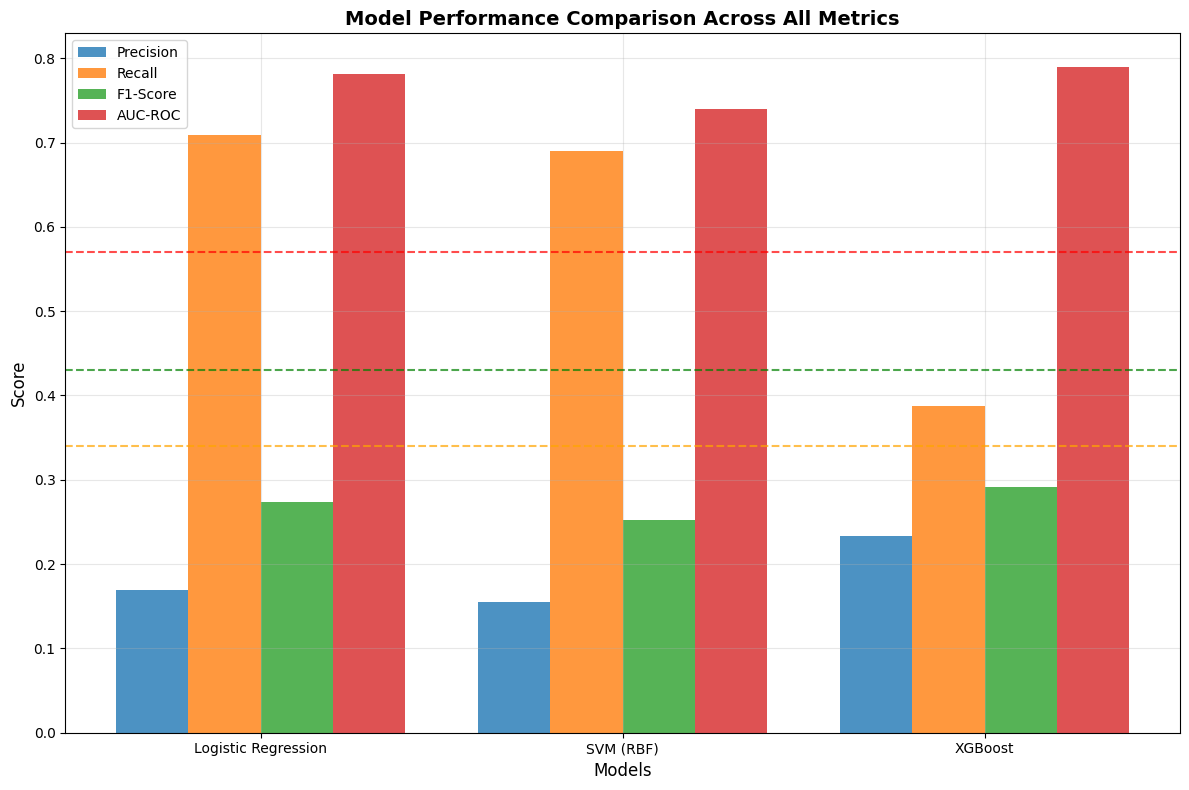

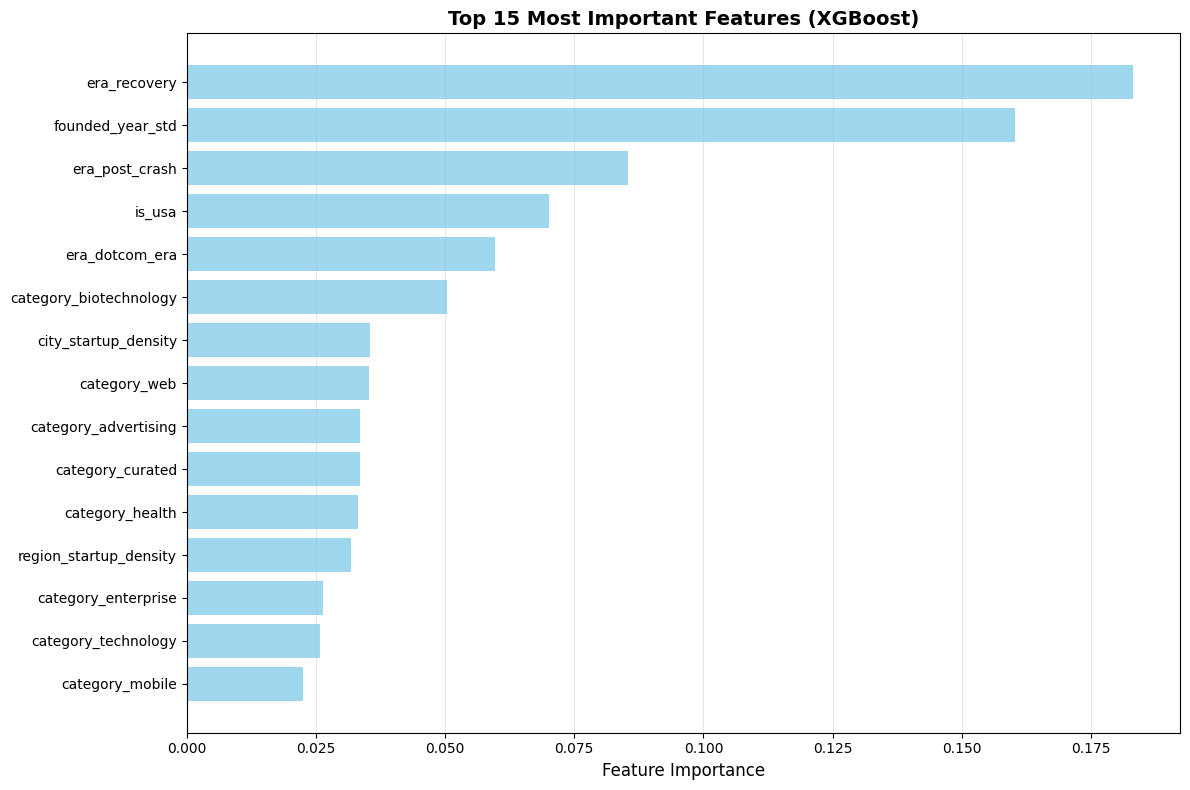

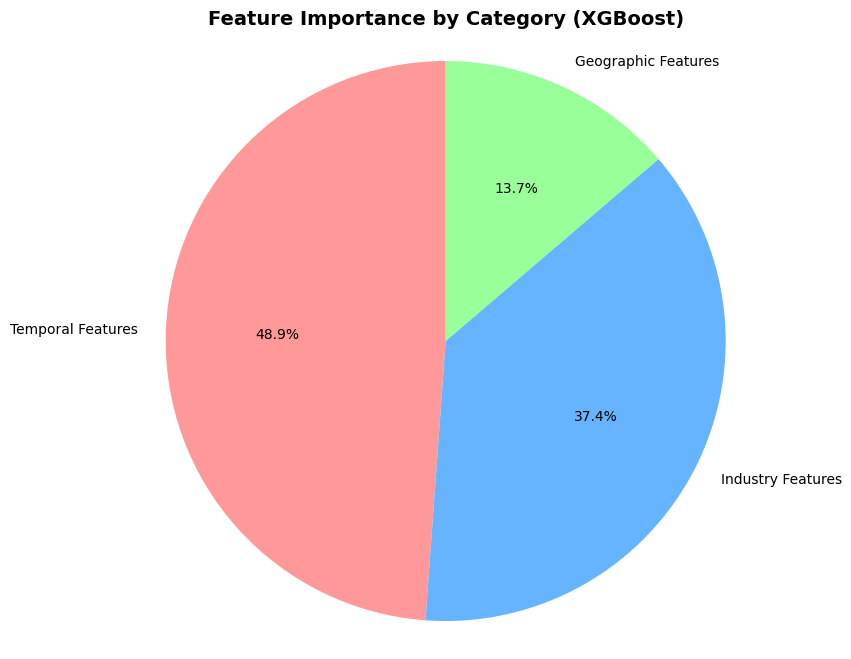

<Figure size 1200x800 with 0 Axes>

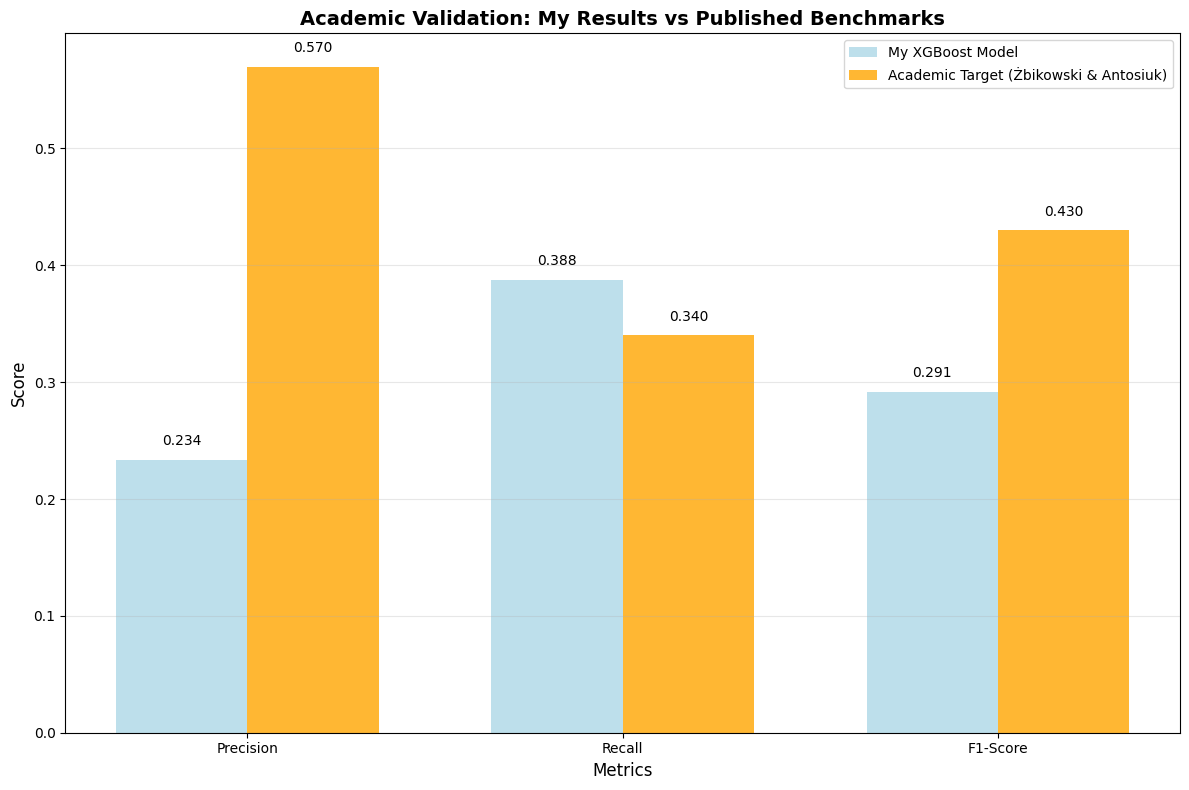

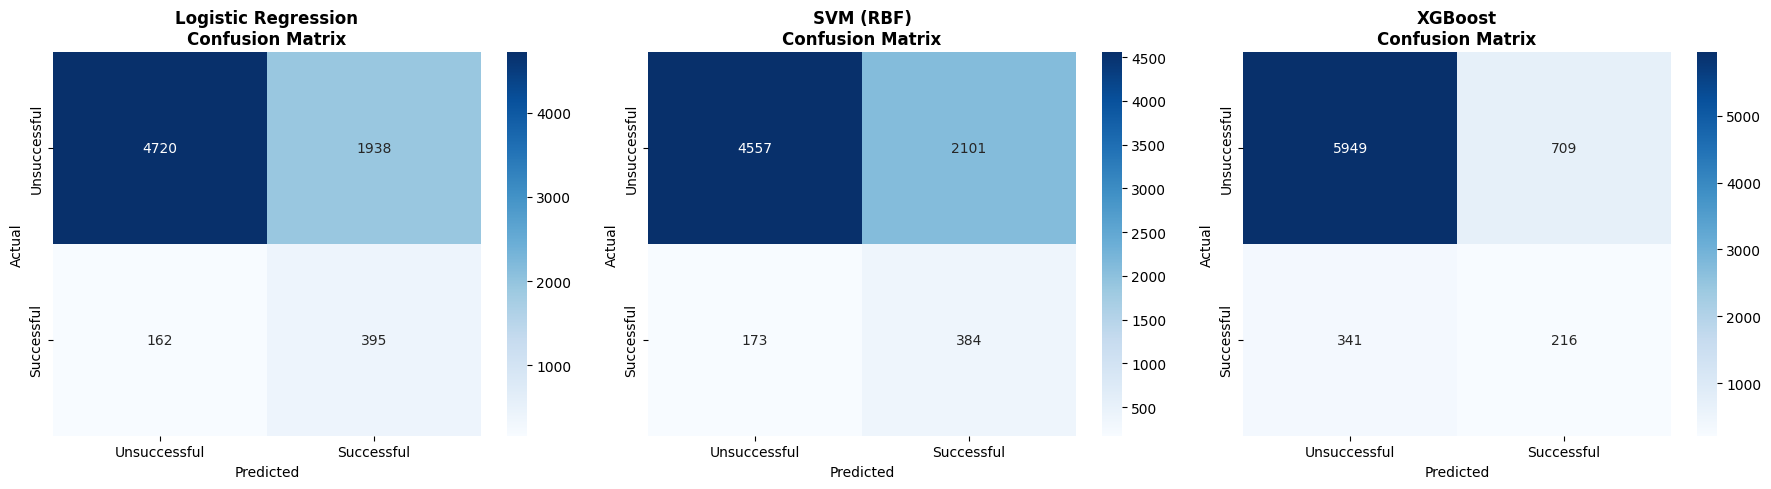

All figures saved to ../results/figures/


In [13]:

# Create figures directory
os.makedirs('../results/figures', exist_ok=True)

# Model Comparison Metrics
plt.figure(figsize=(12, 8))
metrics = ['Precision', 'Recall', 'F1-Score', 'AUC-ROC']
models = ['Logistic Regression', 'SVM (RBF)', 'XGBoost']
model_scores = {
    'Precision': [lr_precision, svm_precision, xgb_precision],
    'Recall': [lr_recall, svm_recall, xgb_recall], 
    'F1-Score': [lr_f1, svm_f1, xgb_f1],
    'AUC-ROC': [lr_auc, svm_auc, xgb_auc]
}

x = np.arange(len(models))
width = 0.2
fig, ax = plt.subplots(figsize=(12, 8))

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, model_scores[metric], width, label=metric, alpha=0.8)

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison Across All Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(models)
ax.legend()
ax.grid(True, alpha=0.3)

# Academic targets as horizontal lines
ax.axhline(y=TARGET_PRECISION, color='red', linestyle='--', alpha=0.7, label='Academic Target')
ax.axhline(y=TARGET_RECALL, color='orange', linestyle='--', alpha=0.7)
ax.axhline(y=TARGET_F1, color='green', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('../results/figures/model_comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature Importance Visualization
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='skyblue', alpha=0.8)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 15 Most Important Features (XGBoost)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('../results/figures/feature_importance_xgboost.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature Category Importance Pie Chart
plt.figure(figsize=(10, 8))
categories = ['Temporal Features', 'Industry Features', 'Geographic Features']
importance_values = [temporal_importance, industry_importance, geo_importance]
colors = ['#ff9999', '#66b3ff', '#99ff99']

plt.pie(importance_values, labels=categories, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Feature Importance by Category (XGBoost)', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.savefig('../results/figures/feature_importance_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

# Academic Benchmark Comparison
plt.figure(figsize=(12, 8))
metrics = ['Precision', 'Recall', 'F1-Score']
my_scores = [xgb_precision, xgb_recall, xgb_f1]
academic_targets = [TARGET_PRECISION, TARGET_RECALL, TARGET_F1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.bar(x - width/2, my_scores, width, label='My XGBoost Model', color='lightblue', alpha=0.8)
bars2 = ax.bar(x + width/2, academic_targets, width, label='Academic Target (Żbikowski & Antosiuk)', color='orange', alpha=0.8)

ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Academic Validation: My Results vs Published Benchmarks', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom')
            
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('../results/figures/academic_benchmark_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Confusion Matrix Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
models_data = [
    ('Logistic Regression', lr_pred),
    ('SVM (RBF)', svm_pred), 
    ('XGBoost', xgb_pred)
]

for idx, (model_name, predictions) in enumerate(models_data):
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Unsuccessful', 'Successful'],
                yticklabels=['Unsuccessful', 'Successful'],
                ax=axes[idx])
    axes[idx].set_title(f'{model_name}\nConfusion Matrix', fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('../results/figures/confusion_matrices_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("All figures saved to ../results/figures/")

## 11. Saving Models and Results

**Purpose**: Persist trained models and evaluation results for future use and deployment

### Key Operations
- **Model Serialization**: Save all three trained models using joblib for efficient storage and loading
- **Results Documentation**: Export performance metrics and feature analysis to CSV format
- **Organized Structure**: Models saved to ../results/models/, results to ../results/ directory

### Models Saved
- **Logistic Regression** (logistic_regression_best.pkl) - Best linear baseline with L1 regularization
- **SVM with RBF Kernel** (svm_rbf_best.pkl) - Non linear classifier with balanced class weights  
- **XGBoost** (xgboost_best.pkl) - Best performing ensemble model with optimal hyperparameters

### Results Exported
- **Model Comparison** (baseline_model_comparison.csv) - Performance metrics across all algorithms
- **Feature Importance** (feature_importance_xgboost.csv) - XGBoost feature rankings and scores

### Output Summary
- **Best Model**: XGBoost with F1-Score of 0.291
- **Models Directory**: 3 trained models
- **Results Files**: Performance benchmarks and feature analysis preserved for reporting

In [14]:
# Saving Models and Results

print("Saving Models and Results")

# Models directory
os.makedirs('../results/models', exist_ok=True)

# Saves best models
joblib.dump(lr_best, '../results/models/logistic_regression_best.pkl')
joblib.dump(svm_best, '../results/models/svm_rbf_best.pkl')
joblib.dump(xgb_best, '../results/models/xgboost_best.pkl')

# Saves results
results_df.to_csv('../results/baseline_model_comparison.csv', index=False)
feature_importance.to_csv('../results/feature_importance_xgboost.csv', index=False)

print("Models saved to ../results/models/")
print("Results saved to ../results/")


Saving Models and Results
Models saved to ../results/models/
Results saved to ../results/


In [23]:
#########################################################
# FEATURE COLUMNS FOR API
#########################################################

# Creates the models directory
models_dir = '../results/models'
os.makedirs(models_dir, exist_ok=True)

# Saves the feature column names (22 features preprocessing)
feature_columns = [
    'region_startup_density', 'city_startup_density', 'is_usa',
    'category_software', 'category_mobile', 'category_social', 'category_media', 
    'category_web', 'category_e-commerce', 'category_biotechnology', 'category_curated',
    'category_health', 'category_advertising', 'category_games', 'category_enterprise', 
    'category_technology', 'category_marketing', 'category_analytics',
    'founded_year_std', 'era_dotcom_era', 'era_post_crash', 'era_recovery'
]

# Saves the feature columns
joblib.dump(feature_columns, os.path.join(models_dir, 'feature_columns.pkl'))

print(f"Feature columns saved successfully to {models_dir}/feature_columns.pkl")
print(f"Number of features: {len(feature_columns)}")
print("Feature columns:", feature_columns)

Feature columns saved successfully to ../results/models/feature_columns.pkl
Number of features: 22
Feature columns: ['region_startup_density', 'city_startup_density', 'is_usa', 'category_software', 'category_mobile', 'category_social', 'category_media', 'category_web', 'category_e-commerce', 'category_biotechnology', 'category_curated', 'category_health', 'category_advertising', 'category_games', 'category_enterprise', 'category_technology', 'category_marketing', 'category_analytics', 'founded_year_std', 'era_dotcom_era', 'era_post_crash', 'era_recovery']


In [22]:
##############################
# CREATES SHAP EXPLAINERS
##############################

import shap
import joblib
import os

# Creates the models directory
models_dir = '../results/models'
os.makedirs(models_dir, exist_ok=True)

# For each model trained 
for model_name, model in [('xgboost', xgb_best), ('logistic', lr_best), ('svm', svm_best)]:
    print(f"Creating explainer for {model_name}...")
    
    if model_name == 'xgboost':
        explainer = shap.TreeExplainer(model)
    elif model_name == 'logistic':
        # LinearExplainer works for Logistic Regression
        X_sample = X_train.sample(min(1000, len(X_train)), random_state=42)
        explainer = shap.LinearExplainer(model, X_sample)
    elif model_name == 'svm':
        # For SVM, use KernelExplainer with a background sample
        X_background = X_train_scaled.sample(min(100, len(X_train_scaled)), random_state=42)
        explainer = shap.KernelExplainer(model.predict_proba, X_background)
    
    # Save using the models_dir variable
    explainer_path = os.path.join(models_dir, f'{model_name}_explainer.pkl')
    joblib.dump(explainer, explainer_path)
    print(f"Saved {model_name} explainer to {explainer_path}")

print("All SHAP explainers created and saved successfully!")

Creating explainer for xgboost...
Saved xgboost explainer to ../results/models\xgboost_explainer.pkl
Creating explainer for logistic...
Saved logistic explainer to ../results/models\logistic_explainer.pkl
Creating explainer for svm...
Saved svm explainer to ../results/models\svm_explainer.pkl
All SHAP explainers created and saved successfully!
